In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

In [84]:
raw_data = pd.read_csv("train.csv")

In [85]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [86]:
raw_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [87]:
raw_data.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


Step 1. Validating and Cleaning data

Text(0.5, 0, 'Lot Frontage (feet)')

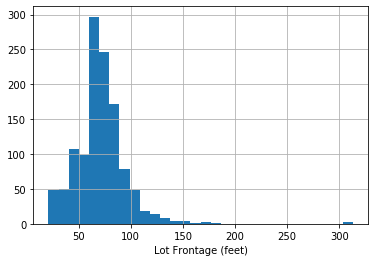

In [88]:
raw_data['LotFrontage'].hist(bins=30)
plt.xlabel("Lot Frontage (feet)")

In [89]:
#Lot Frontage NAs filled with the average value

raw_data['LotFrontage'].fillna(value=raw_data['LotFrontage'].mean(), inplace=True)
raw_data['LotFrontage'].describe()

count    1460.000000
mean       70.049958
std        22.024023
min        21.000000
25%        60.000000
50%        70.049958
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

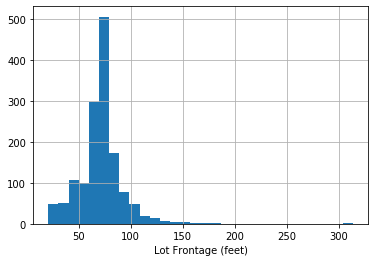

In [90]:
raw_data['LotFrontage'].hist(bins=30)
plt.xlabel("Lot Frontage (feet)");

In [92]:
#in Alley col NA should be replaced by a string that says 'None' because it means there is no alley access
raw_data["Alley"].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [93]:
raw_data["Alley"].fillna(value="None", inplace=True)
raw_data["Alley"].value_counts()

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [94]:
# checking OverallQual and OverallCond -- probably will need to group them, possibly to 3 groups each: poor, average, high

print(raw_data["OverallCond"].value_counts().sort_index())

print(raw_data["OverallQual"].value_counts().sort_index())

1      1
2      5
3     25
4     57
5    821
6    252
7    205
8     72
9     22
Name: OverallCond, dtype: int64
1       2
2       3
3      20
4     116
5     397
6     374
7     319
8     168
9      43
10     18
Name: OverallQual, dtype: int64


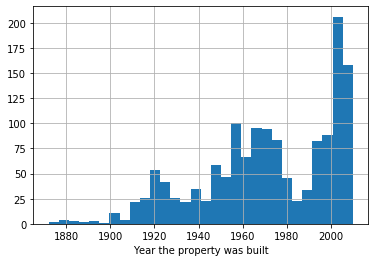

In [95]:
#YearBuilt: should be categorical. Needs grouping according to ranges

raw_data["YearBuilt"].hist(bins=30)
plt.xlabel("Year the property was built");

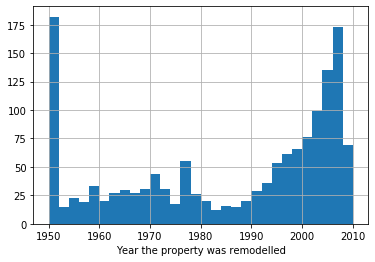

In [96]:
#YearRemodAdd: can be used to create another feature column Remod, which should be 1/0 binary according to the 
#rule YearBuilt==YearRemodAdd then 0 else 1

raw_data["YearRemodAdd"].hist(bins=30)
plt.xlabel("Year the property was remodelled");

In [97]:
# About half the properties in the dataset were remodeled. It would be interesting to see how recent the remodeling was
# referenced to the purchase data

raw_data["Remod"]=0

raw_data.loc[raw_data["YearBuilt"]==raw_data["YearRemodAdd"], "Remod"]=1

raw_data["Remod"].value_counts()

1    764
0    696
Name: Remod, dtype: int64

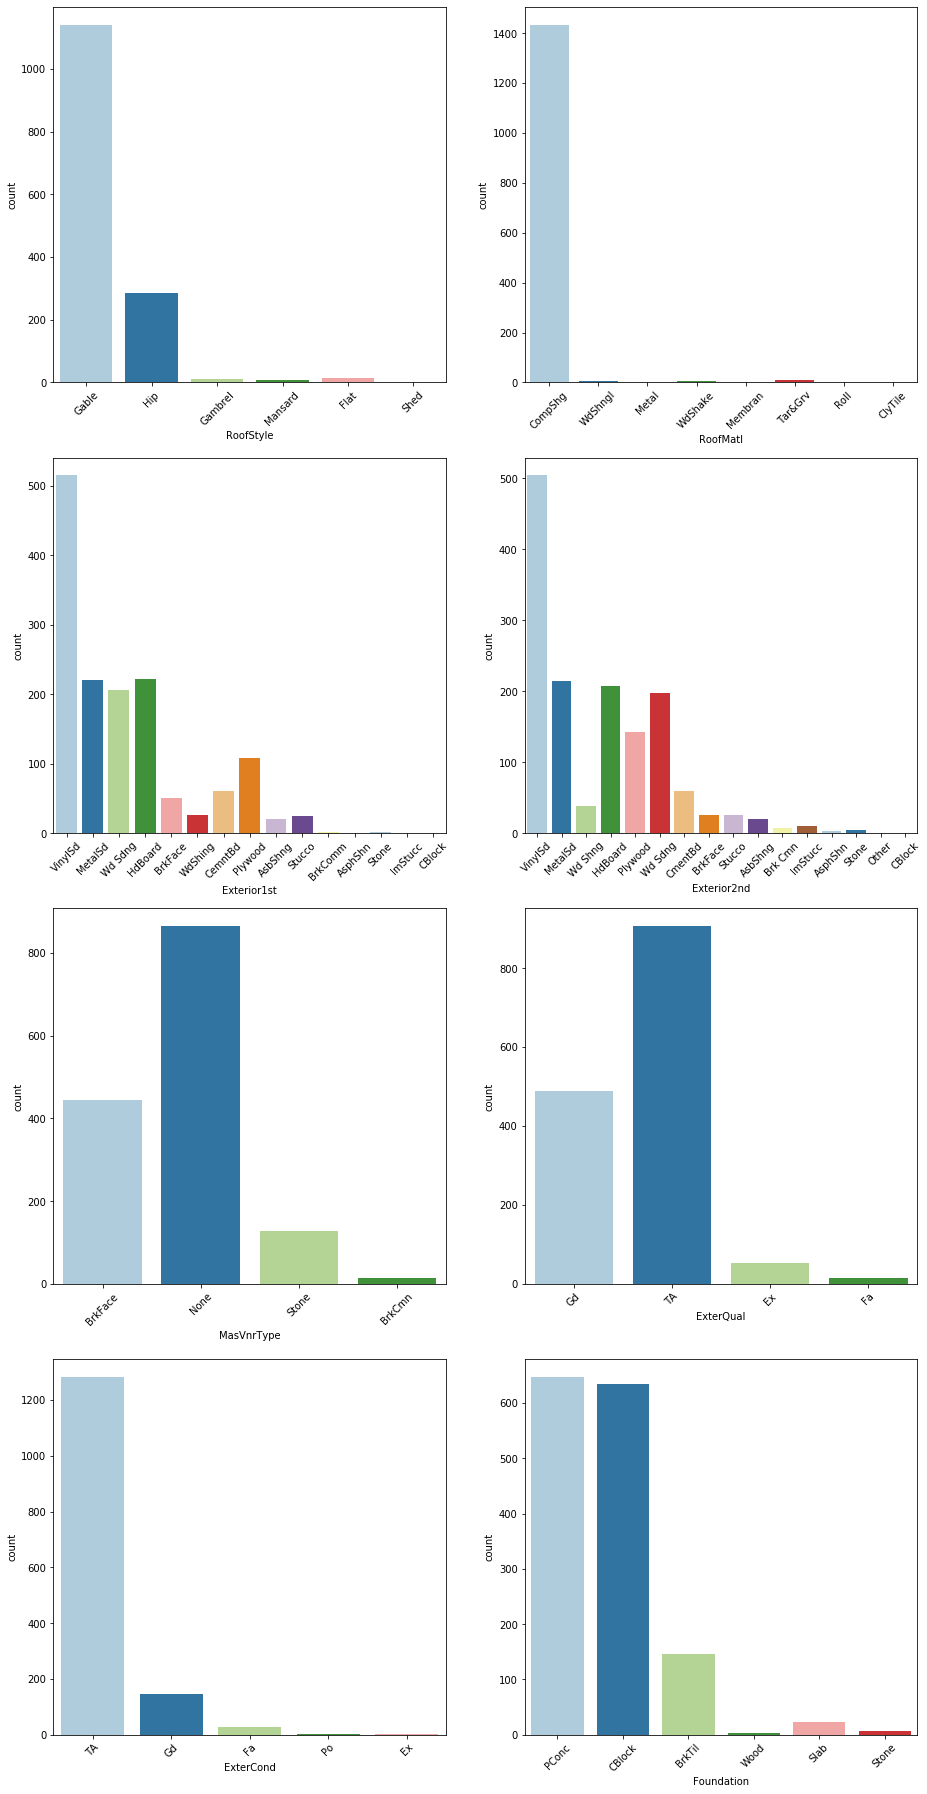

In [98]:
# checking several categorical cols counts for possible groupings

col_list=["RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation"]
if len(col_list)%2==0:
    nrows=len(col_list)//2
else:
    nrows=len(col_list)//2 + 1
    
fig, axes = plt.subplots(nrows,2, figsize=(15,30))
row=0 
col=0
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for column in col_list:
    
    sns.countplot(x=column, data=raw_data, palette="Paired", ax=axes[row,col])
    axes[row,col].set_xticklabels(axes[row,col].get_xticklabels(), rotation=45)
    
    if col==0:
        col=col+1
        
    else:
        row=row+1
        col=0
        

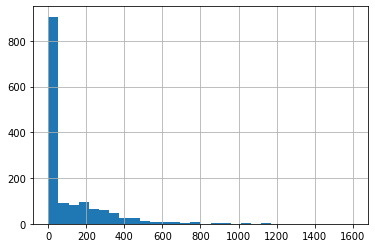

In [102]:
# MasVnrArea have 8 missing values. What does None in MasVnrType correspond to in MasVnrArea ? yes

raw_data["MasVnrArea"].hist(bins=30);
plt.xlabel("Year the property was built");

In [103]:
# will assume the 8 missing values are also corresponding to None and 0.0 in MasVnrType and MasVnrArea.
raw_data["MasVnrType"].fillna(value="None", inplace=True)
raw_data["MasVnrArea"].fillna(value=0.0, inplace=True)

In [104]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non